# Project 2: Student Dropout Classifier
*by Anna Kohnen & Marco Aigner*

This notebook, inspired by [Martins et al.](https://link.springer.com/chapter/10.1007/978-3-030-72657-7_16), demonstrates how to predict students' academic success using different machine-learning algorithms.

---
## Original Research

Martin et al. compared the performance of different machine-learning algorithms on imbalanced data. For this purpose, they initially compared two upsampling techniques, and found the SMOTE algorithm to perform the best. Subsequently, they tested standard machine-learning algorithms and boosting algorithms on a dataset upsampled with SMOTE. They noticed a significant difference between accuracies and f1-scores in imbalanced datasets, indicating that accuracy is a metric not suited for imbalanced data. Overall, they reported best results for boosting models.

---
## The Data
The dataset contains data from students from the Polytechnic Institute of Portalegre. It explicitly only includes information known at the time of students' enrollment and comprises features related to their academic path as well as to demographical and social-economic information. There are both numerical and categorical features included in the dataset.

<div class="alert alert-block alert-info"> <b>Caution:</b> The categorical features are encoded as numbers.</div>

---
## The Tasks
The project comprises 6 tasks, listed as follows:

1. To analyze and explore the dataset. To perform data pre-processing and cleansing.
2. To calculate and visualize the correlation of features among each other and with the labels. To discuss an interesting correlation
3. To train (at least) four machine-learning algorithms: One probabilistic, one tree-based, one distance-based and one ensemble method each.
4. To evaluate the models using k-fold cross-validation. To report accuracy, mean standard deviation and a confusion matrix per model. To discuss whether one model is significantly better than the others
5. To pick two favorite models. To discuss which features were most relevant for the students' success. To discuss differences between the two models
6. So export the best performing model as ONNX to compete against other models

---
# Packages
First, import the necessary packages :

In [1]:
# TODO: Move all imports here
# TODO: Only import the necessary modules to save space
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

# Importing the Data

In [2]:
FILE_NAME = 'train'
DELIMITER = ',' # TODO: parse all files to use comma separation, then drop this

dataframe = pd.read_csv(f'./data/{FILE_NAME}.csv', delimiter=DELIMITER)
dataframe

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
3996,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
3997,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
3998,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


# 1. Exploring and Pre-Processing
The dataframe's ``shape`` attribute provides a tuple with the number of rows and columns:

In [3]:
dataframe.shape

(4000, 37)

```pd.DataFrame.info()``` details the columns' dtypes:

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4000 non-null   int64  
 1   Application mode                                4000 non-null   int64  
 2   Application order                               4000 non-null   int64  
 3   Course                                          4000 non-null   int64  
 4   Daytime/evening attendance	                     4000 non-null   int64  
 5   Previous qualification                          4000 non-null   int64  
 6   Previous qualification (grade)                  4000 non-null   float64
 7   Nacionality                                     4000 non-null   int64  
 8   Mother's qualification                          4000 non-null   int64  
 9   Father's qualification                   

The output verifies that **1.** there are 36 features and one target variable and **2.** that categorical features are numerically encoded.

---
## 1.1 Pre-Processing

Initialize a new dataframe to save the pre-processed data to:

In [5]:
student_data = pd.DataFrame()

For convenience and readabiltiy, transform the column names into ```snake_case```

In [6]:
# create a list of new column names by replacing spaces and '/' with _ and removing the rest
snake_case_columns = dataframe.columns.map(lambda x: x.lower().replace(' ', '_').replace('/','_').replace('(','').replace(')', '').replace('\t', '').replace('\'s','')).to_list()
student_data = dataframe.rename(columns=dict(zip(dataframe.columns, snake_case_columns))) # apply the snake_case column names

Fixe a typo in a column-name:

In [7]:
student_data.rename(columns={'nacionality':'nationality'}, inplace=True)

Categorical columns (known from the [documentation](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)) can be parsed to pandas' explicit ```categorical``` dtype:

In [8]:
# manually create a list of categorical column names
categorical_columns = ['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'nationality', 'mother_qualification', 'father_qualification', 'mother_occupation', 'father_occupation', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'international', 'target']

# assign the categorical dtype to respective columns
student_data[categorical_columns] = student_data[categorical_columns].astype('category')

Numerically encode the targets using a dictionary:

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

student_data['target'] = label_encoder.fit_transform(student_data['target'])

## 1.2 General Exploration

Ensure that no data is missing:

In [10]:
student_data.isnull().values.any() # True if at least a single entry is missing

False

Ensure that there are no duplicates:

In [11]:
student_data.duplicated().values.any() # True if at least a single entry exists twice

False

Inspect random rows of the data:

In [12]:
student_data.sample(n=5)

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
3549,1,1,1,9773,1,1,151.0,2,1,1,...,0,6,6,6,14.166667,0,12.7,3.7,-1.70,2
389,1,1,1,9773,1,1,140.0,1,1,19,...,0,6,7,6,14.571429,0,15.5,2.8,-4.06,2
3318,1,17,1,9070,1,1,118.0,1,38,19,...,0,6,6,6,12.666667,0,7.6,2.6,0.32,2
1718,1,1,1,9853,1,1,142.0,1,12,12,...,0,6,7,5,12.200000,0,7.6,2.6,0.32,2
1644,1,17,1,9500,1,1,137.0,1,19,38,...,0,8,9,8,14.864444,0,15.5,2.8,-4.06,2


Pandas' ``describe()``-method provides useful statistics on the numerical features. 

Notice, how the features' scales differ:

In [13]:
student_data.describe()

,previous_qualification_grade,admission_grade,age_at_enrollment,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000
mean,132.615850,127.055000,23.328250,0.694250,6.246500,8.272000,4.678500,10.624771,0.136250,0.53125,6.21425,8.030750,4.410500,10.201676,0.14950,11.559675,1.221725,-0.007977,1.177750
std,13.236954,14.438823,7.691865,2.320692,2.434999,4.155458,3.069771,4.844416,0.671043,1.87694,2.15859,3.925705,2.991024,5.229377,0.73945,2.673214,1.383045,2.271051,0.890142
min,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,7.600000,-0.800000,-4.060000,0.000000
25%,125.000000,118.000000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.00000,5.00000,6.000000,2.000000,10.750000,0.00000,9.400000,0.300000,-1.700000,0.000000
50%,133.100000,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.00000,6.00000,8.000000,5.000000,12.200000,0.00000,11.100000,1.400000,0.320000,2.000000
75%,140.000000,134.800000,25.000000,0.000000,7.000000,10.000000,6.000000,13.381295,0.000000,0.00000,7.00000,10.000000,6.000000,13.333333,0.00000,13.900000,2.600000,1.790000,2.000000
max,190.000000,190.000000,70.000000,20.000000,23.000000,45.000000,21.000000,18.875000,12.000000,19.00000,23.00000,28.000000,20.000000,17.714286,12.00000,16.200000,3.700000,3.510000,2.000000


``describe()`` on categorical columns provides different statistics, such as the number of unique as well as the most frequent variable

In [14]:
student_data.describe(include=['category'])

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,nationality,mother_qualification,father_qualification,mother_occupation,father_occupation,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,international
count,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,6,18,8,17,2,17,20,28,32,30,43,2,2,2,2,2,2,2
top,1,1,1,9500,1,1,1,1,37,9,9,1,0,0,1,0,0,0
freq,3538,1540,2734,675,3550,3368,3899,971,1115,1430,923,2186,3955,3538,3522,2596,3006,3899


## 1.3 Numerical Features: Scaling
Scale all numerical features to have zero mean and unit variance:

In [15]:
from sklearn.preprocessing import StandardScaler

# new dataframe to store the scaled values
student_data_scaled = student_data.copy()

# select numerical columns by their dtype
numerical_columns = student_data_scaled.select_dtypes(include=['int64', 'float64'])

# initialize a standard scaler with default parameters
standard_scaler = StandardScaler()

# scale numerical columns
scaled = standard_scaler.fit_transform(numerical_columns)

# override scaled columns
student_data_scaled[numerical_columns.columns] = scaled

Notice, how the features are more similar after scaling, which is especially well visible when both plots share their y-axis:

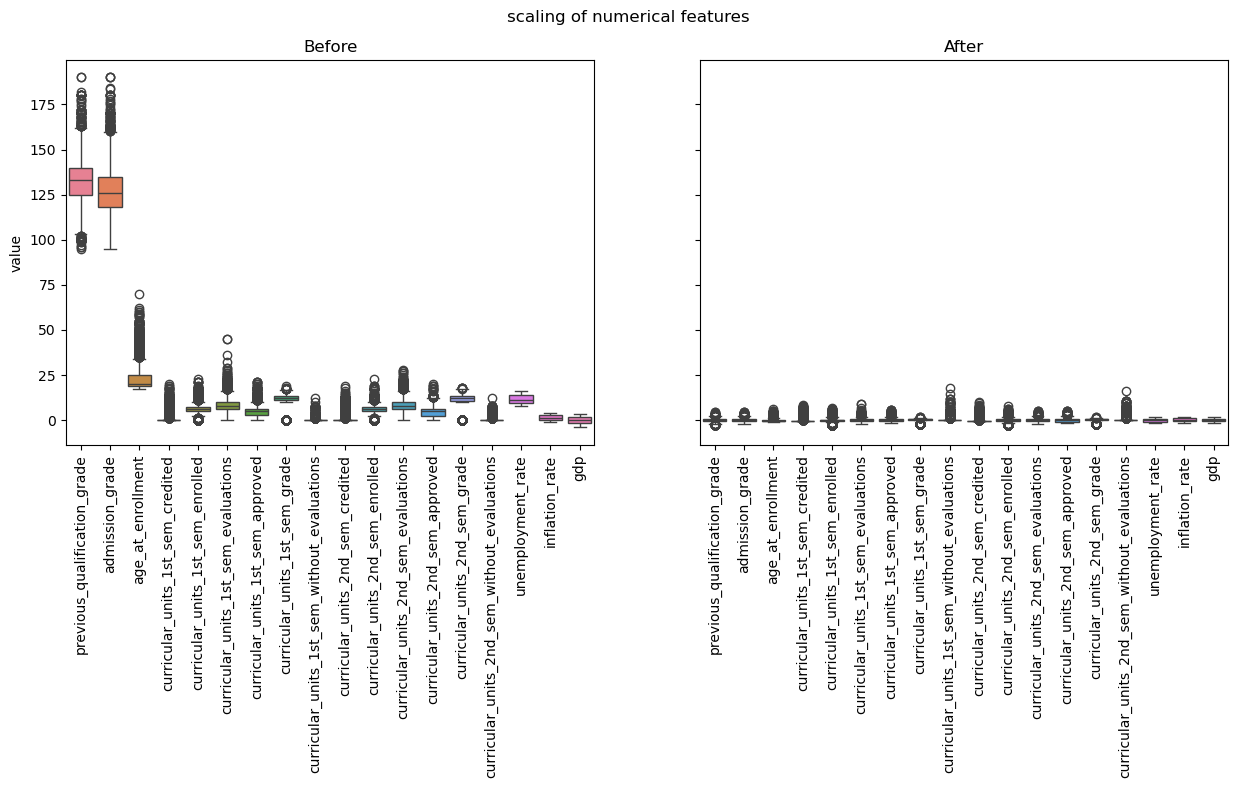

In [16]:
numerical_column_names = numerical_columns.columns.to_list()

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax = ax.flatten()

sns.boxplot(student_data[numerical_column_names], ax=ax[0])

ax[0].set_xticks(numerical_column_names)
ax[0].set_xticklabels(numerical_column_names, rotation=90)
ax[0].set_ylabel('value')
ax[0].set_title('Before')

sns.boxplot(student_data_scaled[numerical_column_names], ax=ax[1])
ax[1].set_xticks(numerical_column_names)
ax[1].set_xticklabels(numerical_column_names, rotation=90)
ax[1].set_title('After')

plt.suptitle('scaling of numerical features')

plt.show()

## 1.4 Categorical Features: One-Hot-Encoding
One-Hot-Encoding creates one column each for distinct values of numerically encoded categorical features so that the models can not accidentally learn ordinal relationships where there are none.

<div class="alert alert-block alert-info"> <b>Omitted: </b>One-Hot-Encoding has been omitted due to time-restrictions but would have been performed otherwise.</div>

## 1.4 Target Variables: Unbalanced Data

Notice, how the dataset is imbalanced, as the 'Graduate' class makes out 50 % of all the data. Such imbalance can lead models to favor the majority classes to achieve higher accuracies.

The imbalance will be dealt with using upsampling-methods later.

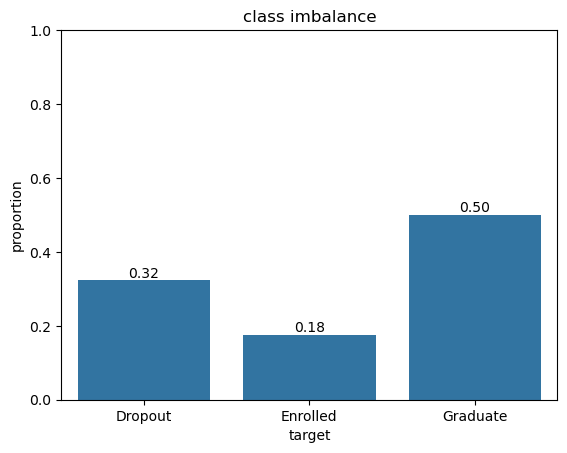

In [17]:
label_distribution = student_data.value_counts(subset=student_data['target'], normalize=True)

fig, ax = plt.subplots()
plot = sns.barplot(data=label_distribution, ax=ax)
plot.set_xticks(range(0, len(label_distribution)))
plot.set_xticklabels(list(label_encoder.classes_))
plot.bar_label(plot.containers[0], fmt='{0:.2f}')
ax.set_ylim(0, 1)
ax.set_title('class imbalance')

plt.show()

# 2. Correlation Analysis

## 2.1 Features With The Target
Features with a very low correlation with the target likely do not provide that much relevant information and are therefore dropped. This allows to focus on highly correlated features instedad.

In [19]:
# correlate each feature column with the target column
corr_feature_target = student_data_scaled.corrwith(other=student_data_scaled['target'], axis='index', drop=False, method='spearman')

# print the sorted correlations
corr_feature_target.sort_values(ascending=True)

age_at_enrollment                              -0.281150
debtor                                         -0.244022
gender                                         -0.225779
application_mode                               -0.209917
previous_qualification                         -0.118788
marital_status                                 -0.103684
curricular_units_2nd_sem_without_evaluations   -0.083841
curricular_units_1st_sem_without_evaluations   -0.080199
curricular_units_1st_sem_evaluations           -0.032583
mother_qualification                           -0.028701
inflation_rate                                 -0.026871
educational_special_needs                      -0.017074
nationality                                     0.005437
international                                   0.005793
course                                          0.014656
curricular_units_1st_sem_credited               0.017472
unemployment_rate                               0.019362
father_qualification           

In general, values closer to 0 indicate a low influence on the target variable, values closer to -1/+1 indicate a higher influence.

Drop all features below with a small correlation below a pre-defined threshhold:

In [20]:
# drop all features with a correlation below 5 %
CORRELATION_TRESHHOLD= 0.05 

# apply the threshhold on the Series
corr_feature_target_threshhold = corr_feature_target[abs(corr_feature_target) >= CORRELATION_TRESHHOLD]

# print the remaining features
corr_feature_target_threshhold_sorted = corr_feature_target_threshhold.sort_values(ascending=True)

# round to two decimals
corr_feature_target_threshhold_sorted = corr_feature_target_threshhold_sorted.round(2)

corr_feature_target_threshhold_sorted

age_at_enrollment                              -0.28
debtor                                         -0.24
gender                                         -0.23
application_mode                               -0.21
previous_qualification                         -0.12
marital_status                                 -0.10
curricular_units_2nd_sem_without_evaluations   -0.08
curricular_units_1st_sem_without_evaluations   -0.08
daytime_evening_attendance                      0.07
application_order                               0.10
previous_qualification_grade                    0.11
displaced                                       0.12
admission_grade                                 0.12
curricular_units_1st_sem_enrolled               0.23
curricular_units_2nd_sem_enrolled               0.24
scholarship_holder                              0.30
tuition_fees_up_to_date                         0.40
curricular_units_1st_sem_grade                  0.50
curricular_units_2nd_sem_grade                

Notice how the number of features shrinked from 36 to 21.

Plot the feature's correlation with the target:

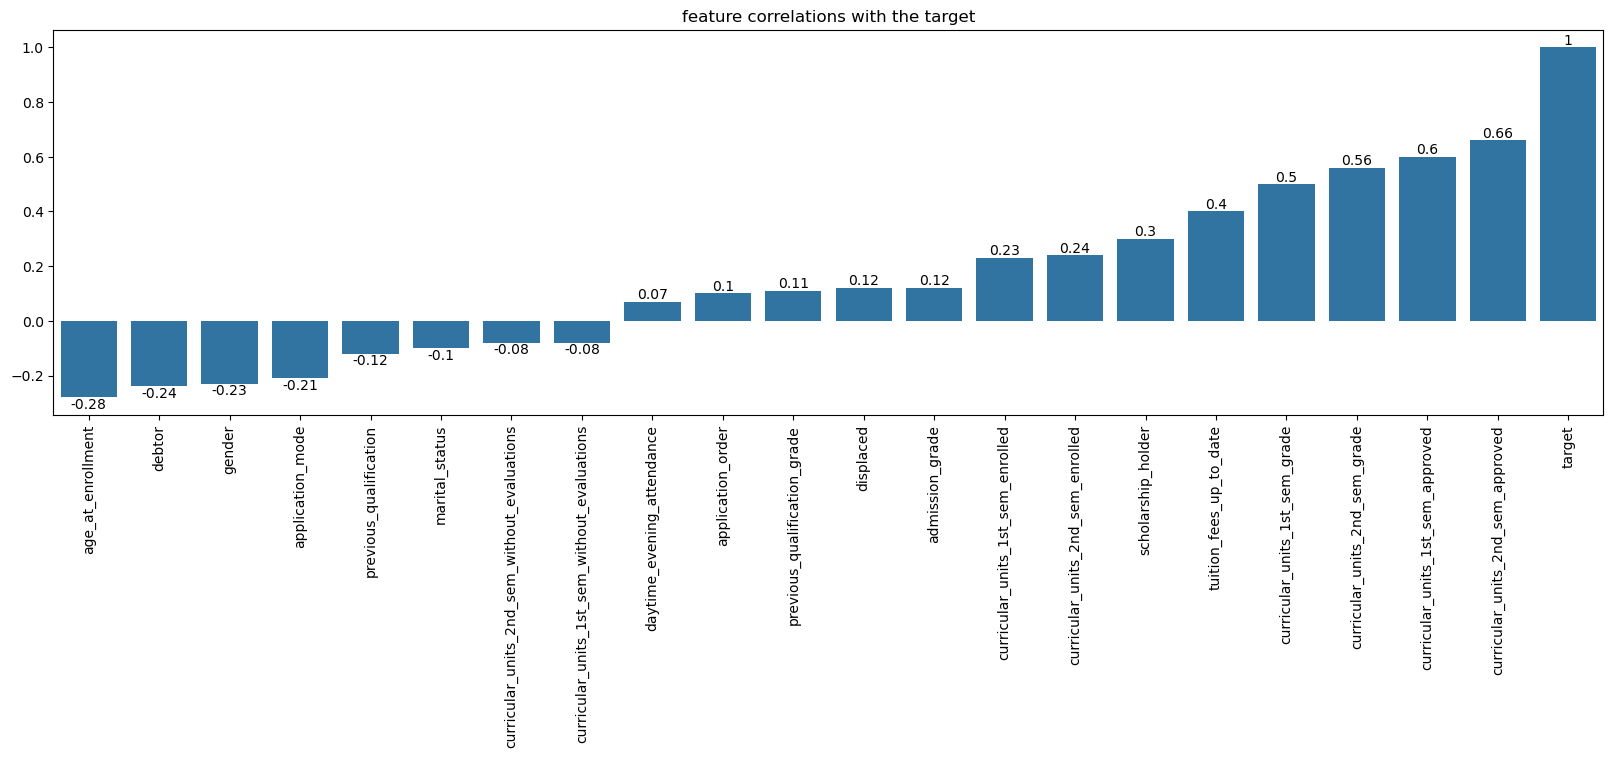

In [21]:
fig, ax = plt.subplots(figsize=(20,5))

ax = sns.barplot(corr_feature_target_threshhold_sorted)
ax.set_xticks(range(0, len(corr_feature_target_threshhold_sorted)))
ax.set_xticklabels(corr_feature_target_threshhold_sorted.index.to_list(), rotation=90)
ax.bar_label(ax.containers[0])
ax.set_title("feature correlations with the target")

plt.show()

The bigger an absolute value, the bigger its influence on the target.

### Discussion
In words this, data indicates for example that a lower age corresponds with higher chances of graduation similarly to how the posession of a scholarship does. This seems to make sense as younger students are known to be more likely to study full-time and as extraordinal grades are a key selection criteron for being awarded a scholarship. Grades and approved curricular units from both semester 1 and 2 seem to have the biggest influence on graduation, while on the other hand it is barely influenced by whether students study during daytime or in the evening.

## 2.2 Features With Each Other
As highly correlated features do not add additional information to the model, aim for features that have a high correlation with the target but a low correlation amongst themselves.

A high correlation between single features demonstrates a linear dependency. Highly correlated features have similar effects on the target and therefore do not necessarily add new information to the models when both present.

Therefore, identify groups of highly correlated features and out of them, pick the one feature with the highest correlation with the target.

First calculate the correlation matrix using only the features with a high correlation with the target

In [22]:
# only use features highly correlated with the target
df_corr_target = student_data_scaled[corr_feature_target_threshhold_sorted.index]

# create the correlation matrix
correlations_features = df_corr_target.corr()

# round to two decimals
correlations_features = correlations_features.round(2) 

correlations_features

,age_at_enrollment,debtor,gender,application_mode,previous_qualification,marital_status,curricular_units_2nd_sem_without_evaluations,curricular_units_1st_sem_without_evaluations,daytime_evening_attendance,application_order,...,admission_grade,curricular_units_1st_sem_enrolled,curricular_units_2nd_sem_enrolled,scholarship_holder,tuition_fees_up_to_date,curricular_units_1st_sem_grade,curricular_units_2nd_sem_grade,curricular_units_1st_sem_approved,curricular_units_2nd_sem_approved,target
age_at_enrollment,1.00,0.10,0.15,0.52,0.15,0.52,0.07,0.06,-0.47,-0.27,...,-0.03,0.14,0.09,-0.19,-0.18,-0.16,-0.18,-0.06,-0.12,-0.24
debtor,0.10,1.00,0.06,0.13,0.09,0.04,0.06,0.01,0.00,-0.07,...,-0.01,-0.00,-0.02,-0.07,-0.42,-0.11,-0.14,-0.10,-0.15,-0.25
gender,0.15,0.06,1.00,0.16,0.07,-0.02,0.07,-0.01,-0.02,-0.08,...,0.02,-0.09,-0.13,-0.17,-0.10,-0.19,-0.20,-0.18,-0.22,-0.23
application_mode,0.52,0.13,0.16,1.00,0.42,0.26,0.05,0.04,-0.31,-0.28,...,-0.01,0.17,0.13,-0.16,-0.14,-0.11,-0.12,-0.03,-0.07,-0.22
previous_qualification,0.15,0.09,0.07,0.42,1.00,0.05,0.01,0.01,-0.08,-0.18,...,0.19,0.09,0.06,-0.07,-0.07,-0.00,0.00,0.03,-0.01,-0.05
marital_status,0.52,0.04,-0.02,0.26,0.05,1.00,0.02,0.04,-0.28,-0.13,...,-0.01,0.05,0.04,-0.05,-0.09,-0.06,-0.07,-0.03,-0.04,-0.09
curricular_units_2nd_sem_without_evaluations,0.07,0.06,0.07,0.05,0.01,0.02,1.00,0.55,-0.00,-0.01,...,-0.02,0.05,0.04,-0.05,-0.08,-0.07,-0.08,-0.07,-0.08,-0.10
curricular_units_1st_sem_without_evaluations,0.06,0.01,-0.01,0.04,0.01,0.04,0.55,1.00,0.05,-0.03,...,0.00,0.11,0.09,-0.06,-0.05,-0.08,-0.06,-0.03,-0.03,-0.07
daytime_evening_attendance,-0.47,0.00,-0.02,-0.31,-0.08,-0.28,-0.00,0.05,1.00,0.16,...,0.01,-0.04,0.00,0.09,0.04,0.06,0.05,0.02,0.04,0.08
application_order,-0.27,-0.07,-0.08,-0.28,-0.18,-0.13,-0.01,-0.03,0.16,1.00,...,-0.10,-0.02,0.03,0.07,0.05,0.06,0.05,0.04,0.07,0.08


To increase reabability, keep only pairwise correlations above a pre-defined threshhold:

In [23]:
CORRELATION_TRESHHOLD = 0.4 # change as desired

# remove correlations below the threshhold
correlations_features_filtered = correlations_features[abs(correlations_features) > CORRELATION_TRESHHOLD]

# round to two decimals
correlations_features_filtered = correlations_features_filtered.round(2)

correlations_features_filtered

,age_at_enrollment,debtor,gender,application_mode,previous_qualification,marital_status,curricular_units_2nd_sem_without_evaluations,curricular_units_1st_sem_without_evaluations,daytime_evening_attendance,application_order,...,admission_grade,curricular_units_1st_sem_enrolled,curricular_units_2nd_sem_enrolled,scholarship_holder,tuition_fees_up_to_date,curricular_units_1st_sem_grade,curricular_units_2nd_sem_grade,curricular_units_1st_sem_approved,curricular_units_2nd_sem_approved,target
age_at_enrollment,1.00,NaN,NaN,0.52,NaN,0.52,NaN,NaN,-0.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debtor,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.42,NaN,NaN,NaN,NaN,NaN
gender,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_mode,0.52,NaN,NaN,1.00,0.42,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_qualification,NaN,NaN,NaN,0.42,1.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,0.52,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
curricular_units_2nd_sem_without_evaluations,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
curricular_units_1st_sem_without_evaluations,NaN,NaN,NaN,NaN,NaN,NaN,0.55,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daytime_evening_attendance,-0.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot the correlations

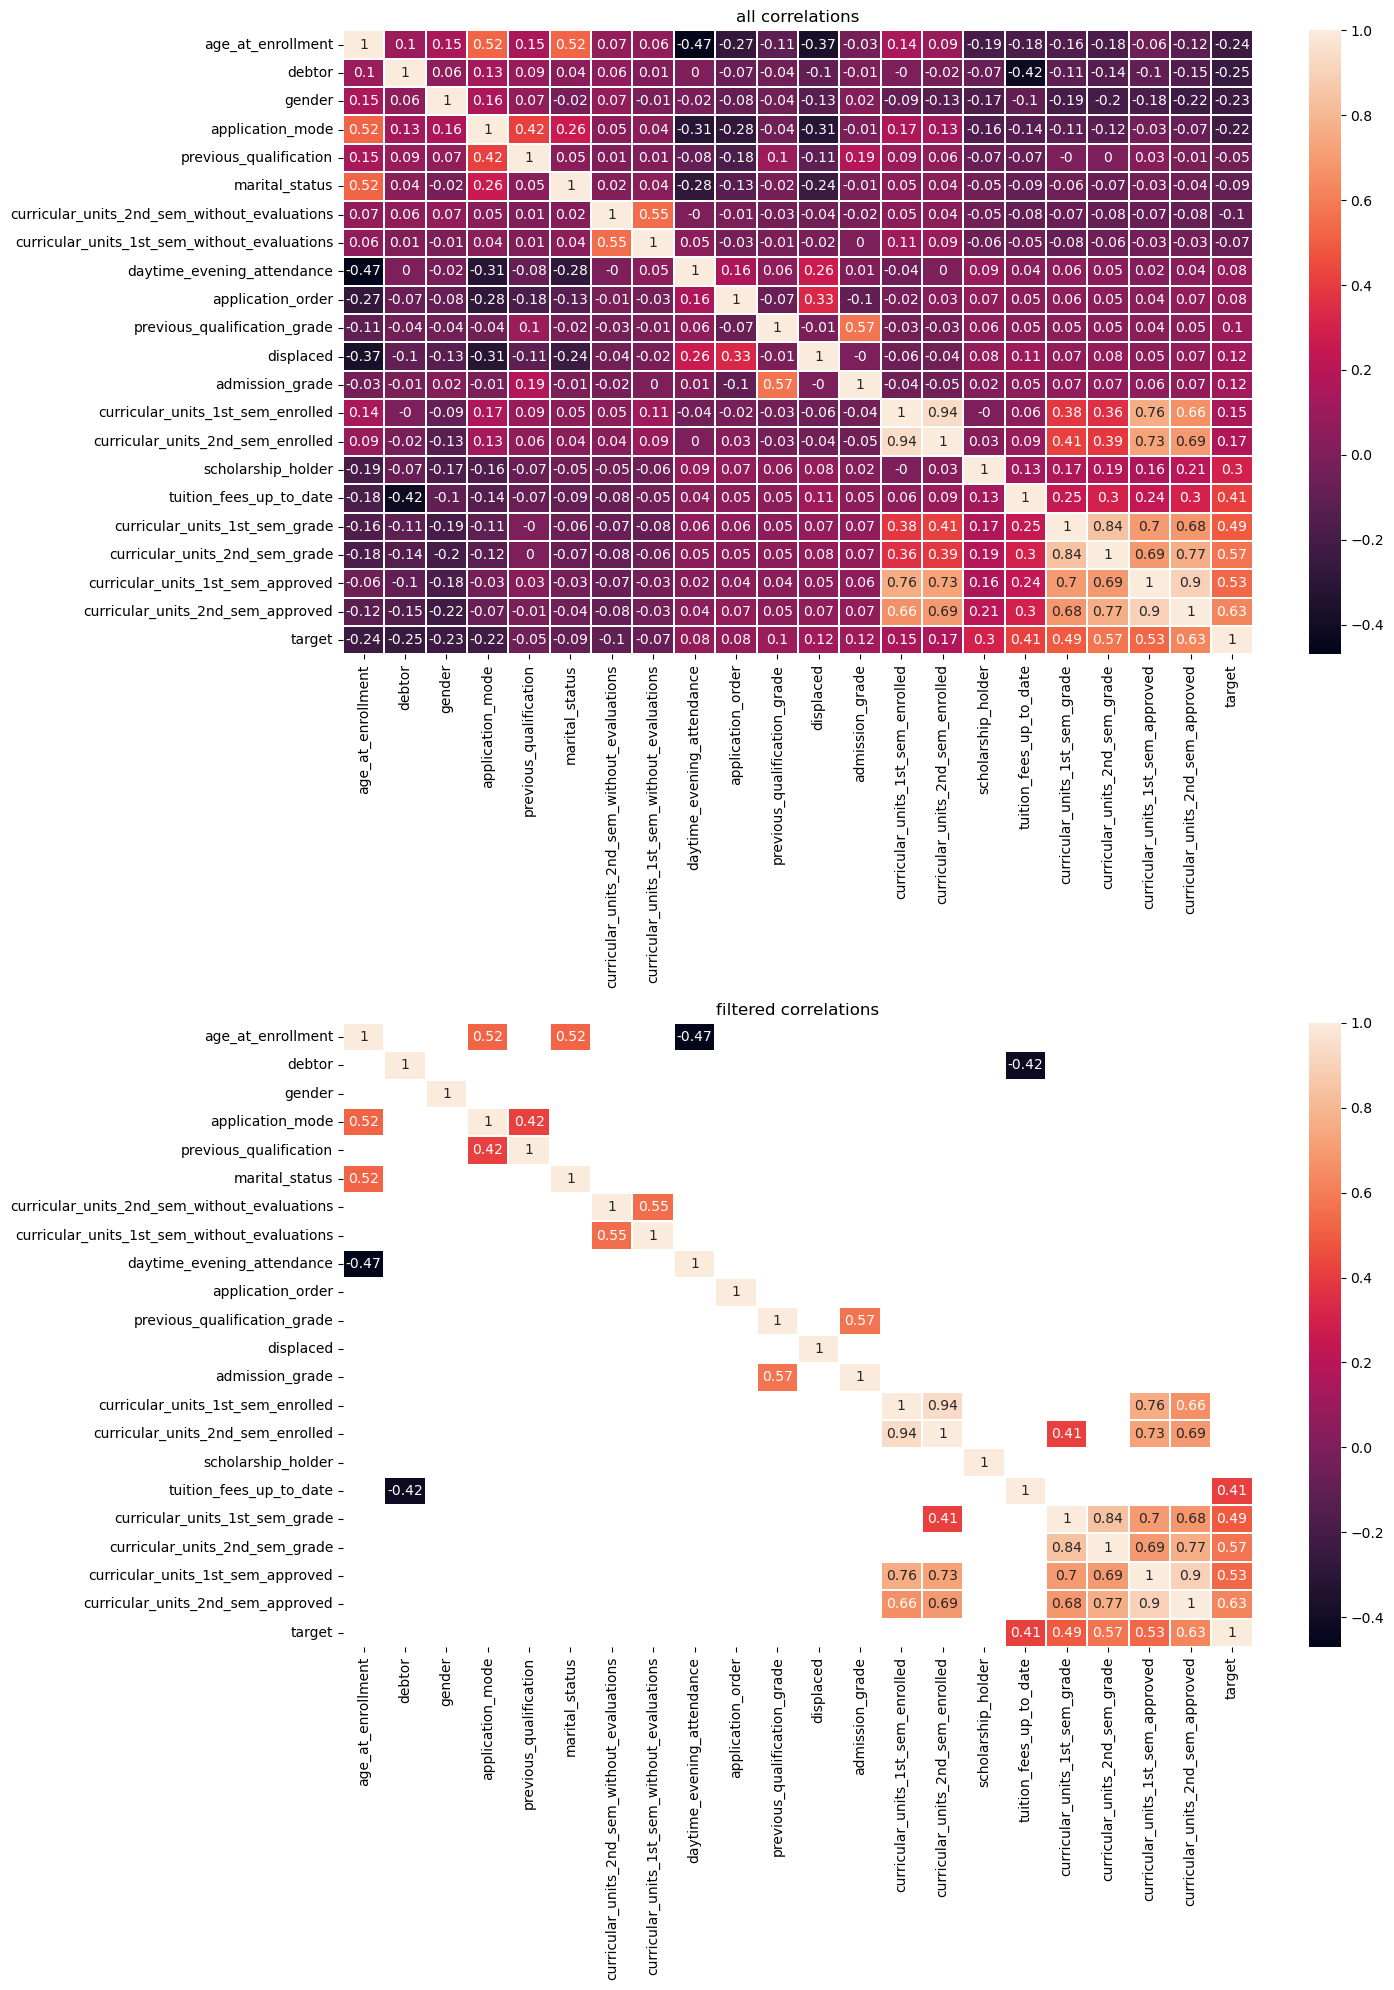

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15,20))

whole = sns.heatmap(data=correlations_features, annot=True, linewidths=0.1, ax=ax[0])
whole.set_title('all correlations')

filtered = sns.heatmap(data=correlations_features_filtered, annot=True, linewidths=0.1, ax=ax[1])
filtered.set_title('filtered correlations')

fig.tight_layout()

plt.show()

### Discussion

A good example for the logic behind correlations can be seem by the ``age at enrollment`` which is highly correlated with three other features, namely the ``application mode``, ``marital status`` and ``daytime/evening attendance``. Knowing that a lot of people marry between the age of 25 and 30, the positive correlation between the age and marital mode makes sense as it states that younger students are less likely to be married. Furthermore, younger students are more likely to be full-time students, while older students are more likely to study part-time next to their job and possibly family. Thus it makes sense that younger full-time students applied through the general contigent and mostly study during daytime.

Another interesting correlation can be seen in ``debtor`` and ``tuition fees up to date``. One could for example argue, how students that forget to pay their tuition fees could also forget to pay back credits which would lead them into debt.

## 2.3 Feature Selection

Out of a group of pairwise correlated features, pick only the one feature which has the highest correlation with the target variable:

In [25]:
to_drop = ['marital_status', 'application_mode', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'debtor', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations' ]

Notice how the number of features got reduced from 36 to 11:

In [26]:
final_dataframe = df_corr_target.drop(columns=to_drop, axis='columns')

final_dataframe

,age_at_enrollment,gender,curricular_units_2nd_sem_without_evaluations,application_order,displaced,admission_grade,curricular_units_2nd_sem_enrolled,scholarship_holder,tuition_fees_up_to_date,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_approved,target
0,-0.432751,1,-0.202203,5,1,0.016970,-2.879206,0,1,-1.951084,-1.474763,0
1,-0.562775,1,-0.202203,1,1,1.069819,-0.099267,0,0,0.662684,0.531490,2
2,-0.562775,1,-0.202203,5,1,-0.156196,-0.099267,0,0,-1.951084,-1.474763,0
3,-0.432751,0,-0.202203,2,1,-0.516381,-0.099267,0,1,0.420432,0.197114,2
4,2.817842,0,-0.202203,1,0,1.000553,-0.099267,0,1,0.535183,0.531490,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.562775,1,-0.202203,6,0,-0.336288,-0.099267,0,1,0.471433,0.197114,2
3996,-0.692799,0,-0.202203,2,1,-0.557941,-0.099267,0,0,0.152680,-0.806012,0
3997,0.867486,0,-0.202203,1,1,1.554684,0.827379,1,1,0.630809,-1.140387,0
3998,-0.432751,0,-0.202203,1,1,1.852529,-0.562590,1,1,0.343932,0.197114,2


# 3. Models

## 3.1 Data Split
Split the data into features (X) and labels (y) in a ration of 80:20 and with a fixed random state for reproducability:

In [27]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2

X = final_dataframe.drop(columns='target')
y = final_dataframe['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=TEST_SIZE,random_state=42)

## 3.2 Upsampling: SMOTE & ADASYN
Martin et al. were using the two upsampling algorithms SMOTE and ADASYNC to even out the targets by synthesizing new data: 

In [28]:
from imblearn.over_sampling import SMOTENC, ADASYN

# initialize the upsamplers
smote = SMOTENC(random_state=42, sampling_strategy='not majority', categorical_features='auto')
adasyn = ADASYN(random_state=42, sampling_strategy='not majority', n_neighbors=5)

# create dataframes to store the upsampled data
X_train_smote, y_train_smote = X_train.copy(), y_train.copy()
X_train_adasyn, y_train_adasyn = X_train.copy(), y_train.copy()

# upsample the data
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote) # type: ignore
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_adasyn, y_train_adasyn) # type: ignore

<div class="alert alert-block alert-danger"> <b>Caution:</b> ADASYN has been found to create NaN-values. Therefore drop all rows containing NaN for ADASYN.</div>

In [29]:
# list of indices with rows containing NaNs
nan_indices = X_train_adasyn[X_train_adasyn.isna().any(axis=1)].index

# drop NaN-rows based on indices for features and labels
X_train_adasyn.drop(index=nan_indices, inplace=True)
y_train_adasyn.drop(index=nan_indices, inplace=True)

Calculate the distributions of the original and the upsampled data:

In [30]:
# calculate the relative distribution of classes
class_distribution = y_train.value_counts(normalize=True)
class_distribution_smote = y_train_smote.value_counts(normalize=True)
class_distribution_adasyn = y_train_adasyn.value_counts(normalize=True)

Visualize the distributions:

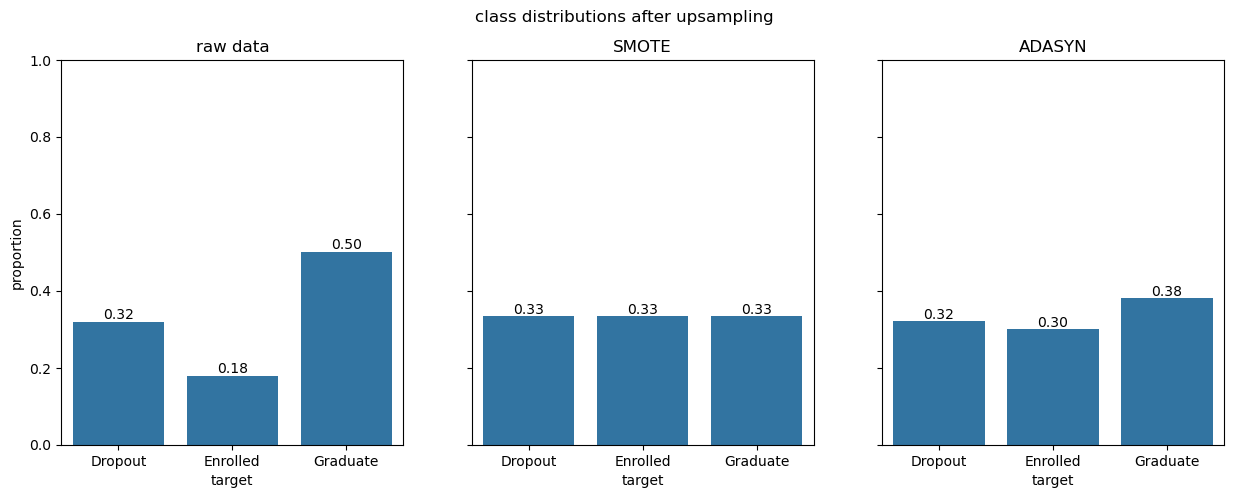

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)

raw = sns.barplot(data=class_distribution, ax=axs[0])
raw.set_xticks(range(0, len(label_distribution)))
raw.set_xticklabels(list(label_encoder.classes_))
raw.bar_label(raw.containers[0], fmt='{0:.2f}') #type: ignore
raw.set_ylim(0, 1)
raw.set_title('raw data')

sm = sns.barplot(data=class_distribution_smote, ax=axs[1])
sm.set_xticks(range(0, len(label_distribution)))
sm.set_xticklabels(list(label_encoder.classes_))
sm.bar_label(sm.containers[0], fmt='{0:.2f}') #type: ignore
sm.set_ylim(0, 1)
sm.set_title('SMOTE')

ads = sns.barplot(data=class_distribution_adasyn, ax=axs[2])
ads.set_xticks(range(0, len(label_distribution)))
ads.set_xticklabels(list(label_encoder.classes_))
ads.bar_label(ads.containers[0], fmt='{0:.2f}') #type: ignore
ads.set_ylim(0, 1)
ads.set_title('ADASYN')

plt.suptitle('class distributions after upsampling')

plt.show()

SMOTE manages to completely equalize the class distribution, while the distribution differs slightly when using ADASYN. The difference with ADASYN is bigger after dropping rows with NaN-values.

Martin et al. compared the three datasets based on accuracy and F1-score on a simple logistic regressor:

In [32]:
# logistic regression with built-in cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# initialize and fit regressors
raw_regressor = LogisticRegression(random_state=42)
smote_regressor = LogisticRegression(random_state=42)
adasyn_regressor = LogisticRegression(random_state=42)

# define metrics for the cross validation
ACCURACY_SCORE = make_scorer(accuracy_score)
F1_SCORE = make_scorer(f1_score, average='macro')

# initialize mapping scorer
scoring = {'accuracy': ACCURACY_SCORE, 'f1': F1_SCORE}

# calculate single accuracies and f1-scores
results_raw = cross_validate(raw_regressor, X_train, y_train, cv=5, scoring=scoring)
results_smote = cross_validate(smote_regressor, X_train_smote, y_train_smote, cv=5, scoring=scoring) # type: ignore
results_adasyn = cross_validate(adasyn_regressor, X_train_adasyn, y_train_adasyn, cv=5, scoring=scoring) # type: ignore

# get the mean accuracy and f1-score
accuracy_raw, f1_raw = results_raw['test_accuracy'].mean(), results_raw['test_f1'].mean()
accuracy_smote, f1_smote = results_smote['test_accuracy'].mean(), results_smote['test_f1'].mean()
accuracy_adasyn, f1_adasyn = results_adasyn['test_accuracy'].mean(), results_adasyn['test_f1'].mean()

Compare the results with Martin et al:

In [33]:
# combine all metrics into one dataframe
upsampling_results = pd.DataFrame(data=[[f1_raw, f1_smote, f1_adasyn], [accuracy_raw, accuracy_smote, accuracy_adasyn]], columns=['Logistic Regression', 'SMOTE + Logistic Regression', 'ADASYN + Logistic Regression'], index=['Average F1-score', 'Accuracy'])

# round to two decimals
upsampling_results = upsampling_results.round(2)

# print the dataframe
upsampling_results

,Logistic Regression,SMOTE + Logistic Regression,ADASYN + Logistic Regression
Average F1-score,0.65,0.73,0.68
Accuracy,0.76,0.73,0.69


![title](./img/upsampling.png)

### Discussion
The results follow Martin et al. in that accuracy and f1-score differ mostly for the original data, strenghening the hypothesis that accuracy alone is not an adequate metric for imbalanced classification problems.

The results also verify SMOTE to yield the best f1-score amongst the three datasets. Therefore, upsampled data using SMOTE will be used for the rest of the notebook.

Interestingly, the present data achieves both a higher accuracy and f1-score than Martin et al. did. This may be due to feature selection but is not clear since Martin et al. did neither report whether they performed feature selection nor how they calculated their metrics.

## 3.3 Model Definition 

Choose one probabilistic, one tree-based, one distance-based and one ensemble method each.

In [34]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator

# map the models to their respective names
models = {
    # Probabilistic Model
    'Gaussian Naive Bayes': GaussianNB(),

    # Distance-Based Model
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),

    # Tree-based Model
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),

    # Ensemble Method
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
}

### Discussion: Models' suitability

- **Gaussian Naive Bayes**: Quick and well suited for classification of normally-distributed numerical features. Usually performs well, even if features are not conditionally independent of each other. Might not perform as well if features are not normally distributed.

- **K-Nearest Neighbors**: Suitable for both numerical and categorical features. Classification is based on the majority class amongst its k-nearest neighbors. Therefore sensitive to its parameter k (number of neighbors). Might have difficulties with noise from high-dimensional data as in many features.

- **Random Forest**: Able to handle many conditionally-dependent features. Provides feature importances out-of-the-box. Less susceptible to to variation in the features and to overfitting than a single decision tree. While its creation is not as easy to follow as a decision-tree one's, its results are generally human-readable.

- **Gradient Boosting**: Creates a strong learner out of a combined series of weak learners. Generally performs well on both numerical and categorical features. The most computationally expensive out of the four models.

*Conclusion*: The Naive Bayes probably yields the worst performance as features are numerical and categorical and not necessarily normally-distributed. Although the dimensions in the dataset have been reduced by feature selection, k-nearest neighbors might still struggle with multiple features. Following the works by Martin et al., Random Forest and Gradient Boosting are exptected to generate the best results.


## 3.4 Model Training

In [35]:
# function to train models
# use the data upsampled using SMOTE by default
def train_model(model_name, model, X_train=X_train_smote, y_train=y_train_smote):
    try:
        # Train the model
        model.fit(X_train.values, y_train.values)
    except Exception as e:
        print(f"Error while training {model_name}: {e}")

In [36]:
# train the models - takes ~ 3 seconds
for model_name, model in models.items():
    train_model(model_name, model)

# 4. Cross-Validation

## 4.1 Cross-Validation

First, define the number of folds for cross-validation and instantiate variables to save the results to.

In [37]:
# number of folds for cross-validation
K_FOLDS = 5

# store the results here
matrices = {}
metrics = pd.DataFrame(columns=['accuracy (mean)', 'accuracy (std)', 'f1 (mean)', 'f1 (std)'], index=list(models.keys()))

Cross-validate each model andcalculate mean and standard deviation for both accuracy and f1-score as well as the confusion matrix. 

Save the results to the respective variables:

In [38]:
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix

for model_name, model in models.items():
    # generate cross-validated estimates
    y_pred = cross_val_predict(model, X_test, y_test, cv=K_FOLDS) # type: ignore

    # calculate confusion-matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # add the confusion matrix to the results
    matrices[model_name] = conf_matrix

    # calculate metrics
    cv_results = cross_validate(model, X_test, y_test, cv=K_FOLDS, scoring=scoring) # type: ignore
    accs = cv_results['test_accuracy']
    f1s  = cv_results['test_f1']

    # write means and standard deviations to the results
    metrics.loc[model_name]['accuracy (mean)'] = accs.mean()
    metrics.loc[model_name]['accuracy (std)'] = accs.std()
    metrics.loc[model_name]['f1 (mean)'] = f1s.mean()
    metrics.loc[model_name]['f1 (std)'] = f1s.std()
    
metrics = metrics.astype(float).round(2)    

## 4.2 Results: Confusion Matrices

Plot the confusion matrices:

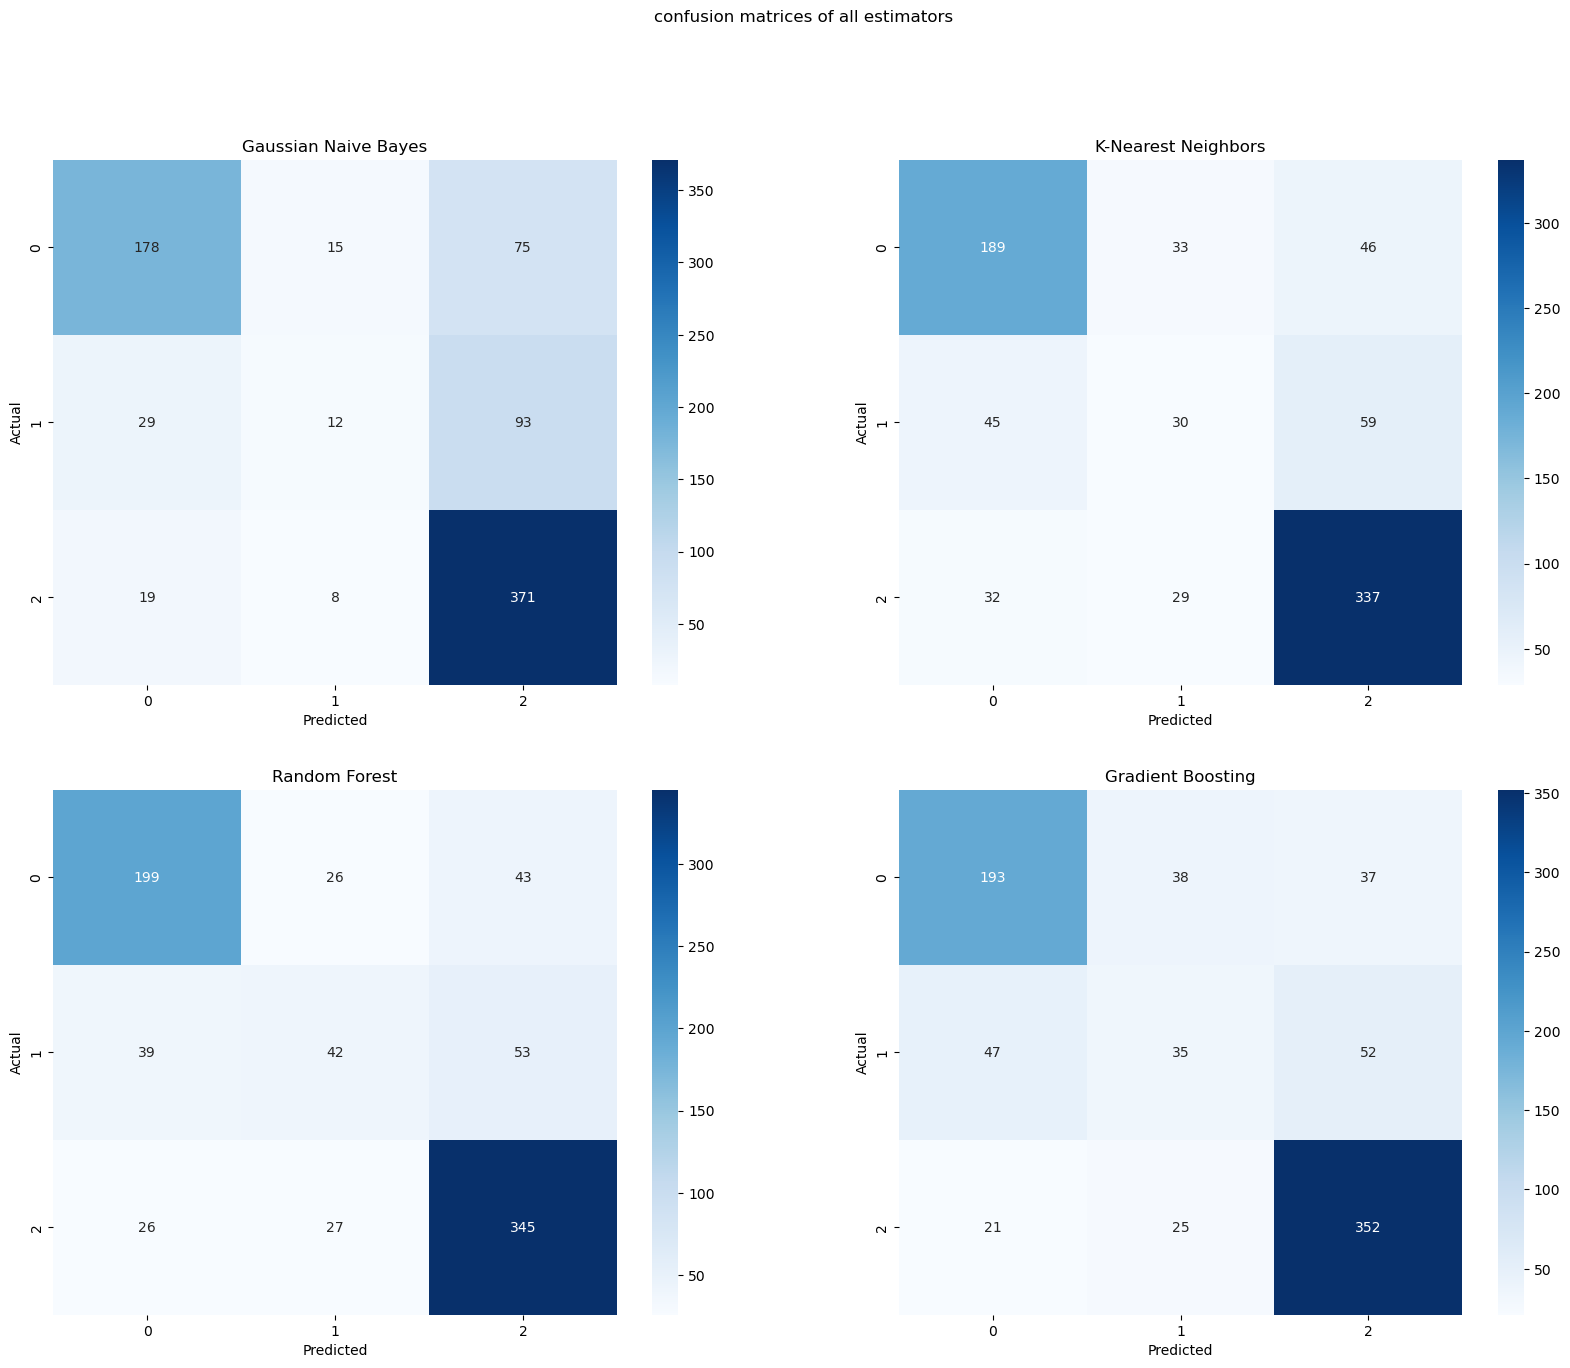

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

axs = axs.flatten()

for idx, (name, matrix) in enumerate(matrices.items()):
    ax = axs[idx]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('confusion matrices of all estimators')

plt.show()

## 4.3 Results: Metrics

Output the cross-validation results:

In [40]:
metrics

,accuracy (mean),accuracy (std),f1 (mean),f1 (std)
Gaussian Naive Bayes,0.70,0.03,0.55,0.04
K-Nearest Neighbors,0.70,0.03,0.59,0.03
Random Forest,0.73,0.03,0.65,0.03
Gradient Boosting,0.72,0.03,0.62,0.03


## 4.4 Discussion
- With regard to the accuracy, all four models seem to perform equally well.
- However, taking into account the f1-scores, results get worse for all and differ more between models. This further demonstrates Martin et al.'s hypothesis on how accuracy becomes reliable with imbalanced datasets. 
- Based on the f1-score, the random forest and gradient boosting classifiers performed the best. 
- Notice the relatively high standard deviation for the Naive Bayes' f1-score, which further illustrates its uncertainty.
- Random Forest achieved to perform significantly better than Naive Bayes with regard to their standard deviations. The other models do not differ significantly.

# 5. Favorite Models
Pick Random Forest and Gradient Boosting as the favorite models as they performed best on the f1-score.

## 5.1 Feature Importances

Conveniently, both favorite models provide feature importances out-of-the-box:

In [41]:
feature_importances_rf = models['Random Forest'].feature_importances_
feature_importances_gb = models['Gradient Boosting'].feature_importances_

Plot the features importances:

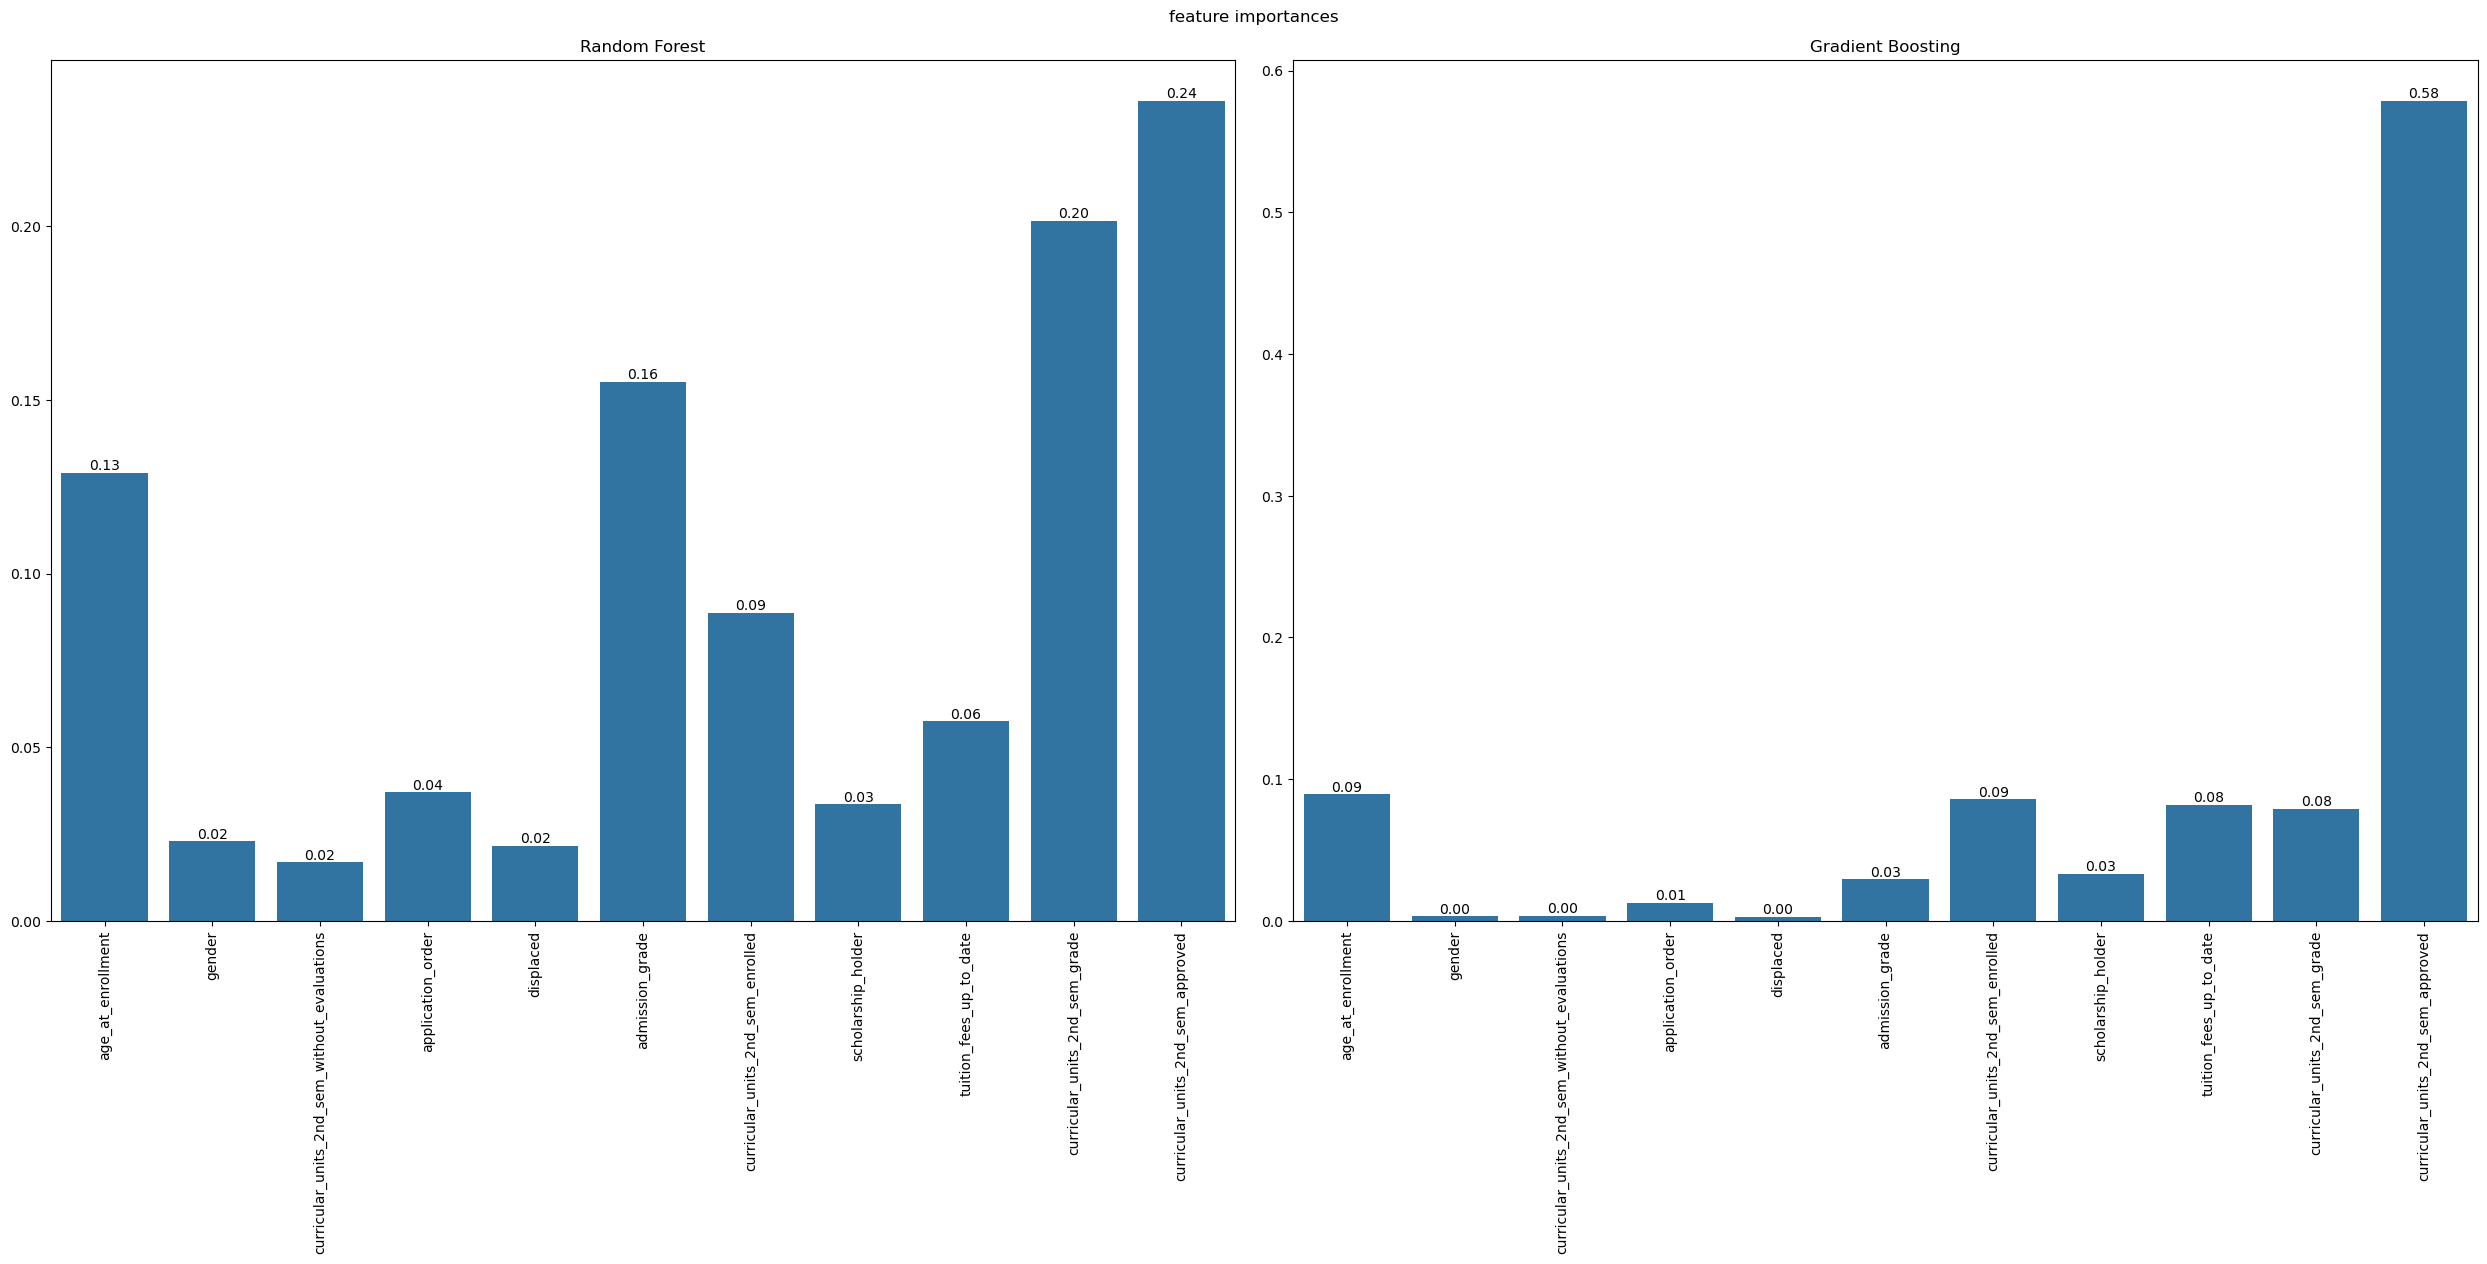

In [42]:
feature_names = final_dataframe.columns.drop('target')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,10))

fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore

#axs = axs.flatten()

rf_plot = sns.barplot(data=feature_importances_rf, ax=axs[0])
rf_plot.set_xticks(range(0, len(feature_importances_rf)))
rf_plot.set_xticklabels(feature_names, rotation=90)
rf_plot.bar_label(rf_plot.containers[0], fmt='{0:.2f}') #type: ignore
rf_plot.set_title('Random Forest')

gb_plot = sns.barplot(data=feature_importances_gb, ax=axs[1])
gb_plot.set_xticks(range(0, len(feature_importances_gb)))
gb_plot.set_xticklabels(feature_names, rotation=90)
gb_plot.bar_label(gb_plot.containers[0], fmt='{0:.2f}') #type: ignore
gb_plot.set_title('Gradient Boosting')


plt.suptitle('feature importances')

plt.show()

## 5.2 Discussion

- Which features were the most relevant for students' success differs strongly based on the models
    - Gradient Boosting 
        - Mostly relied on the approved curricular units from the 2nd semester and 
        - Gave weak importance to the age at enrollmend, tuition fees up to date and enrollment and grade of curricular units from the 2nd semester
        - Rest of features unimportant
    - Random Forest takes more features into account
        - Highest importance for curricular units approval & grades almost equally
        - Medium importance for the admission grade and the age at enrollment
        - Weak importance for the enrollment of curricular units and tuition fees up to date
        - Rest of features unimportant
- Interestingly, approved curricular units 2nd semester, the feature with the highest importance according to both models, also had the highest correlation with the target.

### 5.3 Conclusion
- Especially interesting is how, features very important for the random forest, like the admission grade and curricular unit's grade, are significantly less important for the gradient boosting, as it almost only focuses on the approved curricular units.
- While model simplicity is generally favored, it seems that the Gradient Boosting may simplify to much
    - This hypothesis is backed by the better performance of the Random Forrest
- The students' success may be best predicted by their curricular units from the 2nd semester.

## 6. Model Export

In [43]:
# TODO